# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
import igraph as ig 
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio

In [2]:
data_processed = "../../data/processed/"
data_interim = "../../data/interim/"
data_external = "../../data/external/"

graph_node_data = pd.read_csv(data_processed+"graph_node_table.csv", index_col=0).reset_index(drop=True).astype({"node_name":"string"})
graph_edge_data = pd.read_csv(data_processed+"graph_edge_table.csv", index_col=0).reset_index(drop=True).rename(columns={"relation":"edge_type"}).astype({"edge_idx":"int64"})

prime_node_data = pd.read_csv(data_interim+"primekg_exploring_node_table.csv", index_col=0).reset_index(drop=True)
prime_edge_data = pd.read_csv(data_interim+"primekg_exploring_graph_edge_table.csv",index_col=0).reset_index(drop=True).rename(columns={"relation":"edge_type"})

node_counts = dict(graph_node_data.node_type.value_counts())
node_counts["total"] = sum(node_counts.values())

edge_counts = dict(graph_edge_data.edge_type.value_counts())
edge_counts["total"] = sum(edge_counts.values())

display(pd.DataFrame.from_dict({"Número de nodos":node_counts}, orient="columns"))
display(pd.DataFrame.from_dict({"Número de enlaces":edge_counts}, orient="columns"))

/tmp/ipykernel_70365/1427069343.py:6: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  graph_edge_data = pd.read_csv(data_processed+"graph_edge_table.csv", index_col=0).reset_index(drop=True).rename(columns={"relation":"edge_type"}).astype({"edge_idx":"int64"})


,Número de nodos
disease,18548
gene/protein,16672
protein_complex,422
total,35642


,Número de enlaces
GDA,84038
PPI,150685
forms_complex,1888
parent_child_mondo,30419
total,267030


Setup varios

In [3]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

Armo un subgrafo enfermedad-enfermedad y le agrego sus atributos

In [4]:
def attributes_from_pd(G:nx.Graph,df:pd.DataFrame,attributes:dict,indexcol):
    """Dados un grafo G y un dataframe df con atributos de sus nodos, especificamos los atributos
    que queremos agregar a los nodos en un diccionario con formato {nombre_columna:nombre_atributo}. 
    La función arma un diccionario con los atributos y el nombre que le queremos poner, indexado con el identificador de nodo que elegimos 
    y los asigna a los nodos del grafo"""
    for attribute,name in attributes.items():
        nx.set_node_attributes(G,pd.Series(df.set_index(indexcol)[attribute]).to_dict(),name)

def get_node_dict(G):
    return {node:data for (node,data) in list(G.nodes(data=True))}

In [5]:
edges_enfermedades = graph_edge_data[graph_edge_data.edge_type == "parent_child_mondo"]
nodos_enfermedades = graph_node_data[graph_node_data.node_type == "disease"]
DD = nx.from_pandas_edgelist(edges_enfermedades,source="a_idx",target="b_idx",edge_attr="edge_idx")
DD_attributes = {"node_type":"node_type","node_name":"node_name","node_id":"node_id","node_source":"node_source","disgenet_type":"disgenet_type","diseaseClassMSH":"diseaseClassMSH","diseaseClassNameMSH":"diseaseClassNameMSH"}
attributes_from_pd(DD,graph_node_data,DD_attributes,"node_idx")

# Comunidades: particiones infomap y louvain

In [6]:
def particion_a_diccionario(Red_igraph,particion_igraph):
  particion_dict = {}
  for cluster in range(len(particion_igraph)):
    for nodo in Red_igraph.vs(particion_igraph[cluster])['name']:
      particion_dict.update({nodo:cluster})
  return particion_dict

def particiones(G):
    dict = {}
    G_igraph = ig.Graph.TupleList(G.edges(), directed=False)
    comunidades_infomap  = G_igraph.community_infomap()
    dict_comunidades_infomap = particion_a_diccionario(G_igraph,comunidades_infomap)
    modularidad_infomap = G_igraph.modularity(comunidades_infomap)
    dict['Infomap'] = {'comunidades' : comunidades_infomap, 'diccionario':dict_comunidades_infomap, 'modularidad':modularidad_infomap}

    #LA FUNCIÓN COMMUNITY_MULTILEVEL DE IGRAPH UTILIZA EL ALGORITMO LOUVAIN
    G_igraph = ig.Graph.TupleList(G.edges(), directed=False)
    comunidades_louvain = G_igraph.community_multilevel()
    dict_comunidades_louvain = particion_a_diccionario(G_igraph,comunidades_louvain)
    modularidad_louvain = G_igraph.modularity(comunidades_louvain)
    dict['Louvain'] = {'comunidades' : comunidades_louvain, 'diccionario':dict_comunidades_louvain, 'modularidad':modularidad_louvain}
    return dict

In [7]:
comunidades_dd = particiones(DD)

col_infomap = pd.Series(comunidades_dd['Infomap']['diccionario'],name="comunidades_infomap")
col_louvain = pd.Series(comunidades_dd['Louvain']['diccionario'],name="comunidades_louvain")

nx.set_node_attributes(DD,comunidades_dd['Infomap']['diccionario'],name="comunidad_infomap")
nx.set_node_attributes(DD,comunidades_dd['Louvain']['diccionario'],name="comunidad_louvain")

graph_node_data = pd.merge(graph_node_data,col_infomap,left_on="node_idx",right_index=True, how="left")
graph_node_data = pd.merge(graph_node_data,col_louvain,left_on="node_idx",right_index=True, how="left")

In [8]:
tamaños_infomap = pd.Series(col_infomap.value_counts(), name="tamaño")
tamaños_louvain = pd.Series(col_louvain.value_counts(), name="tamaño")

fig_dist_infomap = px.histogram(tamaños_infomap, title="Distribución de tamaños de clusters - Infomap").update_layout(xaxis_title="Tamaño")
fig_dist_infomap.show()

fig_dist_louvain = px.histogram(tamaños_louvain, title="Distribución de tamaños de clusters - Louvain").update_layout(xaxis_title="Tamaño")
fig_dist_louvain.show()

stats = {"Infomap":{"Num_clusters":len(tamaños_infomap),"Modularidad":round(comunidades_dd["Infomap"]["modularidad"],2)}, "Louvain":{"Num_clusters":len(tamaños_louvain),"Modularidad":round(comunidades_dd["Louvain"]["modularidad"],2)}}

display(pd.DataFrame(stats))

,Infomap,Louvain
Num_clusters,862.00,189.00
Modularidad,0.72,0.82


# Análisis TF-IDF de comunidades

Por un lado está la partición infomap, tengo criterios de similaridad de genes compartidos o similaridad TF-IDF. La idea es ver si los elementos de los clusters infomap son similares entre si segun estos criterios. 

Para cada cluster infomap, calcular la similaridad media de sus componentes y calcular una distribución de estos mismos valores para pares tomados al azar. 
Estandarizar: (z = x- <x>)/sigma -> sobre el sampleo nulo. También se puede ver el p-value.
Grafico z en función del tamaño.

Zgen vs ZIDF y tamaño-> tamaño del cluster y veo todo junto

En primer lugar voy a tratar de asociar terminos biomédicos a comunidades. Para esto voy a tratar cada comunidad como un "documento" y al conjunto de los documentos de todas las comunidades como un "corpus". Con esto voy a hacer un análisis TF-IDF y ver los términos con score TF-IDF más alto.

Además, quiero ver si una comunidad tiene muchos términos asociados con puntaje medio-bajo, versus una con pocos términos y puntaje alto. Para esto se me ocurrió medir la entropía de las distribuciones (normalizadas).

In [9]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
custom_stopwords = ["disease","syndrome","familial","congenital","disorder","type","association","abnormality"]
stop_words = text.ENGLISH_STOP_WORDS.union(custom_stopwords)

## Preprocessing
Armado del corpus y el "documento" de cada cluster y preprocesado de texto. 

No remuevo ni separo las palabras con "-", porque al ser vocabulario biomédico, hay muchos términos que llevan guiones. Por ejemplo: 'peutz-jeghers syndrome', 'bannayan-riley-ruvalcaba syndrome', 't-cell'. Por eso en sklern uso un tokenizer custom, para no perder estos casos.

In [10]:
def remove_symbols(data):
    symbols = "!-\"\'#$%&()*+/:;<=>?@[\]^_`{|},~\n"
    for i in symbols:
        data = np.char.replace(data, i, ' ')
    return data

def doc_to_bow(data):
    bow = []
    for text in data:
        split = text.split()
        for word in split:
            bow.append(word)
    return bow

def filter_stopwords(bow):
    return [word for word in bow if not word in stop_words]

def cluster_as_document(cluster_id,cluster_algorithm,join_titles=True):
    titles = graph_node_data.loc[graph_node_data[cluster_algorithm] == cluster_id, "node_name"].values.astype(str)
    titles = np.char.lower(titles)
    titles = remove_symbols(titles)
    if join_titles:
        document = " ".join(titles)
    else:
        document = titles
    return document

def get_tfidf_df(ngram_range,corpus,ids,df=True):
    vectorizer = TfidfVectorizer(tokenizer = lambda document: document.split() , stop_words=stop_words, ngram_range=ngram_range,min_df=2,max_df=0.3)
    X = vectorizer.fit_transform(corpus)
    if df:
        #X = pd.DataFrame(X.toarray(), index=ids, columns=vectorizer.get_feature_names_out())
        X = pd.DataFrame.sparse.from_spmatrix(X, index=ids, columns=vectorizer.get_feature_names_out())
    return X

def wordcloud_from_tfidf(df,cluster_id):
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(df.loc[cluster_id])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### Casos para filtrar

Voy a inspeccionar un poco a mano algunos términos que veo que se repiten y son un poco molestos para el análisis, para agregarlos a un filtro de palabras que voy a sacar. 

Por ejemplo, el uso de "-" y ".". Se usan "-" en nombres de enfermedades y vocabulario de cromosomas, entonces no los puedo filtrar. Pero además hay muchos términos escritos con "-related" "-induced" que no quiero! Voy a ver como hago para quedarme con los que si quiero y evitar esos.

In [16]:
custom_filter = {"-induced": " induced", "-related":" related", "-specific": " specific", "non-": "non ", "-producing": " producing", "-dependent":" dependent", "-independent": " independent", "-associated": " associated", "-like":" like"}

Arranco con "-"

In [27]:
graph_node_data.loc[graph_node_data.node_type == "disease","node_name"].apply(lambda x: "-" in str(x)).value_counts()

False    15720
True      2828
Name: node_name, dtype: int64

In [18]:
graph_node_data[(graph_node_data["node_name"].apply(lambda x: "-" in str(x))) & (graph_node_data.node_type == "disease")]["node_name"].values

<StringArray>
[                                                      'Abnormalities, Drug-Induced',
                                                              'Acute-Phase Reaction',
                                                         'Osteoporosis, Age-Related',
                                                                 'alpha-Thalassemia',
                                                'Sertoli-Leydig cell tumor of ovary',
                                                       'Arthritis, Adjuvant-Induced',
                                                 'Auriculo-Ventricular Dissociation',
                                                       'Beckwith-Wiedemann Syndrome',
                                                          'Bernard-Soulier Syndrome',
                                                               'Bundle-Branch Block',
 ...
                                                  'non-infectious diarrheal disease',
                                   

In [59]:
graph_node_data.loc[graph_node_data.node_type == "disease","node_name"].apply(lambda x: "-Like" in str(x)).value_counts()

False    18532
True        16
Name: node_name, dtype: int64

In [56]:
graph_node_data[(graph_node_data["node_name"].apply(lambda x: "-Associated" in str(x))) & (graph_node_data.node_type == "disease")]["node_name"].values

<StringArray>
[                             'Neoplasms, Therapy-Associated',
                 'Mucosa-Associated Lymphoid Tissue Lymphoma',
                     'Enteropathy-Associated T-Cell Lymphoma',
                   'HIV-1-Associated Cognitive Motor Complex',
                      'HIV-Associated Lipodystrophy Syndrome',
   'Pulmonary Hypertension, Primary, Fenfluramine-Associated',
                    'Cryopyrin-Associated Periodic Syndromes',
 'Lymphoproliferative Syndrome, Ebv-Associated, Autosomal, 1',
                      'Dmd-Associated Dilated Cardiomyopathy',
        'Fatty Acid Hydroxylase-Associated Neurodegeneration']
Length: 10, dtype: string

In [74]:
casos_guiones = graph_node_data[(graph_node_data["node_name"].apply(lambda x: "-" in str(x))) & (graph_node_data.node_type == "disease")]["node_name"].values.astype(str)
casos_guiones = np.char.lower(casos_guiones)
bow_guiones = doc_to_bow(casos_guiones)
bow_guiones = [term for term in bow_guiones if "-" in term]

bow = []
for text in bow_guiones:
    split = text.split("-")
    bow.append(split[-1])

In [75]:
from collections import Counter
counts = Counter(bow)
print(counts)

Counter({'linked': 183, 'related': 111, 'onset': 94, 'like': 88, 'cell': 77, 'tooth': 70, 'induced': 55, 'linked,': 55, 'intellectual': 54, '': 51, 'associated': 43, 'danlos': 35, 'coa': 29, 'dystroglycanopathy': 25, 'biedl': 22, 'related,': 22, 'onset,': 22, 'rod': 21, 'facial': 19, 'short': 19, 'resistant': 18, 'producing': 18, 'dependent': 16, 'blackfan': 16, 'girdle,': 15, 'rib': 15, 'cleft': 13, 'deafness': 12, 'wiedemann': 11, 'walker': 11, 'pudlak': 11, 'rich': 11, 'renal': 11, 'phosphate': 11, 'type': 11, 'dreifuss': 10, 'limb': 10, 'cerebellar': 10, 'cardiac': 10, 'positive': 9, 'responsive': 9, 'methylglutaconic': 9, 'channel': 9, 'pick': 8, 'goutieres': 8, 'sensitive': 8, 'dependent,': 8, 'gorlin': 8, 'developmental': 8, 'barre': 7, 'negative': 7, 'stromal': 7, 'girdle': 7, 'loken': 7, 'girdle),': 7, 'barr': 7, 'hodgkin': 6, 'willi': 6, 'polydactyly': 6, 'merzbacher': 6, 'digital': 6, 'eye': 6, 'healing': 6, 'cone': 6, 'syndactyly': 6, 'dysmorphism': 6, 'hydroxyglutaric': 6,

In [66]:
bow_guiones

['drug-induced',
 'acute-phase',
 'age-related',
 'alpha-thalassemia',
 'sertoli-leydig',
 'adjuvant-induced',
 'auriculo-ventricular',
 'beckwith-wiedemann',
 'bernard-soulier',
 'bundle-branch',
 'non-small',
 'cervico-brachial',
 'charcot-marie-tooth',
 'chediak-higashi',
 'cri-du-chat',
 'cruveilhier-baumgarten',
 'dandy-walker',
 'dejerine-sottas',
 'insulin-dependent',
 'non-insulin-dependent',
 'camurati-engelmann',
 'drug-induced',
 'ehlers-danlos',
 'ellis-van',
 'tonic-clonic',
 'favre-racouchot',
 'fazio-londe',
 'fructose-1,6-diphosphatase',
 'gerstmann-straussler-scheinker',
 'open-angle',
 'graft-vs-host',
 'foreign-body',
 'guillain-barre',
 'hallervorden-spatz',
 'harding-passey',
 'noise-induced',
 'post-infarction',
 'hemolytic-uremic',
 'veno-occlusive',
 'hippel-lindau',
 'langerhans-cell',
 'impulse-ridden',
 'pseudo-obstruction',
 'creutzfeldt-jakob',
 'late-infantile',
 'jervell-lange',
 'kearns-sayre',
 'klippel-feil',
 'klippel-trenaunay-weber',
 'lambert-eaton

## Calculo matrices TF-IDF

Obtengo ngrams n=1,2,3 para las particiones infomap y louvain

In [11]:
infomap_ids = pd.unique(graph_node_data.loc[~graph_node_data.comunidades_infomap.isna(),"comunidades_infomap"])
louvain_ids = pd.unique(graph_node_data.loc[~graph_node_data.comunidades_louvain.isna(),"comunidades_louvain"])

corpus_infomap = [cluster_as_document(cluster_id,"comunidades_infomap") for cluster_id in infomap_ids]
corpus_louvain = [cluster_as_document(cluster_id,"comunidades_louvain") for cluster_id in louvain_ids]

tfidf_infomap = get_tfidf_df((1,1),corpus_infomap,infomap_ids).sparse.to_dense()
tfidf_infomap_bigrams = get_tfidf_df((2,2),corpus_infomap,infomap_ids).sparse.to_dense()
tfidf_infomap_trigrams = get_tfidf_df((3,3),corpus_infomap,infomap_ids).sparse.to_dense()

tfidf_louvain = get_tfidf_df((1,1),corpus_louvain,louvain_ids).sparse.to_dense()
tfidf_louvain_bigrams = get_tfidf_df((2,2),corpus_louvain,louvain_ids).sparse.to_dense()
tfidf_louvain_trigrams = get_tfidf_df((3,3),corpus_louvain,louvain_ids).sparse.to_dense()


Un ejemplo de como queda la matriz TF-IDF para la partición infomap, viendo solo monogramas

In [12]:
tfidf_infomap

,1,10,10q23,11,12,13,14,15,15q11,15q11q13,...,xi,xii,xx,xy,yellow,yolk,yuan,zellweger,zinc,zone
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
494.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
767.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
848.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Tomo de ejemplo un cluster según infomap. Voy a ver los títulos de enfermedades que aparecen y después los términos con mayor score TF-IDF.

In [13]:
ejemplo = 421
cluster_as_document(ejemplo,"comunidades_infomap",False)

array(['peutz jeghers syndrome', 'bannayan riley ruvalcaba syndrome',
       'cronkhite canada syndrome', 'juvenile polyposis syndrome',
       'juvenile polyposis hereditary hemorrhagic telangiectasia syndrome  disorder ',
       'familial intestinal polyposis',
       'sessile serrated polyposis cancer syndrome',
       'generalized juvenile polyposis juvenile polyposis coli',
       'peutz jeghers syndrome', 'hereditary mixed polyposis syndrome',
       'intestinal polyposis syndrome', 'intestinal polyposis syndrome',
       'hyperplastic polyposis syndrome', 'juvenile polyposis of infancy',
       'colon serrated polyposis'], dtype='<U76')

In [14]:
fig1 = px.bar(tfidf_infomap.loc[ejemplo].sort_values(ascending=False)[0:10])
fig1.show()

fig2 = px.bar(tfidf_infomap_bigrams.loc[ejemplo].sort_values(ascending=False)[0:10])
fig2.show()

fig3 = px.bar(tfidf_infomap_trigrams.loc[ejemplo].sort_values(ascending=False)[0:10])
fig3.show()

### Entropía de distribuciones de términos por clusters

Viendo los resultados para distintos tamaños de clusters ví que en algunos casos hay términos con importancia más "marcada", mientras que en otros no se puede distinguir términos más importantes que otros. En el primer caso, unos pocos términos tienen una frecuencia alta y el resto es más baja. En el segundo, muchos términos tienen una frecuencia media.

Para "medir" esto se me ocurrió normalizar y calcular la entropía de la distribución, pero no sé si estará bien...
La idea es que si las frecuencias dan muy parejas (como equiprobables), tf idf no me dice nada y es como si hubiera juntado términos random -> entropía alta
Si hay pocas frecuencias muy marcadas -> entropía baja

Ejemplo de dos distribuciones, una de un cluster grande y otro más pequeño. La idea es que la entropía de la primer distribución debería ser mayor a la de la segunda.

In [489]:
fig1 = px.bar(tfidf_infomap.loc[116].sort_values(ascending=False)[0:20])
fig1.show()

fig2 = px.bar(tfidf_infomap.loc[421].sort_values(ascending=False)[0:20])
fig2.show()

Calculo la entropía para todos los clusters 

In [15]:
import scipy.stats
from scipy.stats import entropy
def get_entropy(series,normalized=True):
    """Calcula la entropía para una columna de valores de pandas. 
    La extrae como un array y la normaliza para que la suma sea 1 y después calcula la entropía.
    La normalizo por la entropía máxima posible, que sería la distribución uniforme pi=1/(b-a) para valores entre b y a. 
    En este caso es simplemente 1/ el largo del array"""
    values = series.values
    arr = values/(np.sum(values))
    max_entropy = entropy(np.ones(len(arr))/len(arr), base=2)
    if normalized:
        S = round(entropy(arr, base=2)/max_entropy,2)
    else:
        S = round(entropy(arr, base=2))
    return S

Comparo la distribución de puntajes tf-idf normalizados para dos clusters con entropías alta y baja:

S big cluster = 0.84 
S small cluster = 0.32


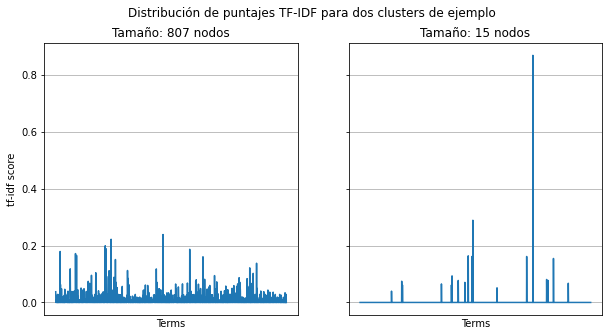

In [17]:
big_cluster = 116
small_cluster = 421

fig, ax = plt.subplots(1,2,figsize=(10,5), sharey=True)
fig.suptitle("Distribución de puntajes TF-IDF para dos clusters de ejemplo \n")

ax[0].set_xticks([])
ax[0].set_title(f"Tamaño: {tamaños_infomap.loc[big_cluster]} nodos")

ax[1].set_xticks([])
ax[1].set_title(f"Tamaño: {tamaños_infomap.loc[small_cluster]} nodos")

tfidf_infomap.loc[big_cluster].plot(ax=ax[0], xlabel='Terms', ylabel='tf-idf score')
tfidf_infomap.loc[ejemplo].plot(ax=ax[1], xlabel='Terms')

ax[0].grid(True)
ax[1].grid(True)

print(f"S big cluster = {get_entropy(tfidf_infomap.loc[big_cluster])} \nS small cluster = {get_entropy(tfidf_infomap.loc[small_cluster])}")

Grafico entropía vs tamaño de cluster para las dos particiones

/tmp/ipykernel_70365/1242770178.py:9: RuntimeWarning:

invalid value encountered in true_divide



Text(0, 0.5, 'Entropía')

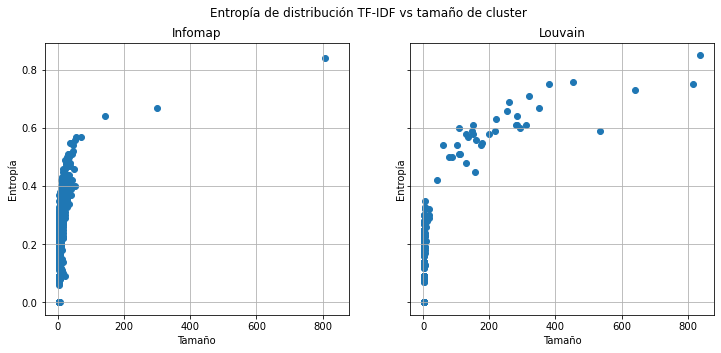

In [18]:
entropias_infomap = [get_entropy(tfidf_infomap.loc[cluster]) for cluster in tamaños_infomap.index]
entropias_louvain = [get_entropy(tfidf_louvain.loc[cluster]) for cluster in tamaños_louvain.index]

fig, ax = plt.subplots(1,2,figsize=(12,5), sharex=True, sharey=True)
fig.suptitle("Entropía de distribución TF-IDF vs tamaño de cluster")
ax[0].scatter(tamaños_infomap.values,entropias_infomap)
ax[0].set_title("Infomap")
ax[0].grid(True)
ax[0].set_xlabel("Tamaño")
ax[0].set_ylabel("Entropía")

ax[1].scatter(tamaños_louvain.values,entropias_louvain)
ax[1].set_title("Louvain")
ax[1].grid(True)
ax[1].set_xlabel("Tamaño")
ax[1].set_ylabel("Entropía")

Junto todos los resultados en un dataset por cada partición, donde voy a reportar por cada cluster: tamaño, entropía de scores tf-idf, top 5 monogramas y bigramas (listas), top ngram con su score para n:1,2,3.

Lo reporto así porque creo que varía entre clusters cual es el dato que mejor lo describe.

Me pareció que para tener un buen resumen del cluster alcanza con ver los datos del dataframe y el score que tiene asociado, para también saber que tan confiable es.

In [19]:
def top_ngrams(monogram_matrix,bigram_matrix,trigram_matrix,clusters):
    all_stats = {}
    for cluster in clusters:
        stats = {}
        stats["top_monogram"] = monogram_matrix.loc[cluster].idxmax()
        stats["top_monogram_score"] = round(monogram_matrix.loc[cluster].max(),2)
        stats["top_bigram"] = bigram_matrix.loc[cluster].idxmax()
        stats["top_bigram_score"] = round(bigram_matrix.loc[cluster].max(),2)
        stats["top_trigram"] = trigram_matrix.loc[cluster].idxmax()
        stats["top_trigram_score"] = round(trigram_matrix.loc[cluster].max(),2)
        all_stats[cluster] = stats
    return all_stats

In [20]:
monograms_infomap = {cluster:tfidf_infomap.loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in infomap_ids}
monograms_louvain = {cluster:tfidf_louvain.loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in louvain_ids}

bigrams_infomap = {cluster:tfidf_infomap_bigrams.loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in infomap_ids}
bigrams_louvain = {cluster:tfidf_louvain_bigrams.loc[cluster].sort_values(ascending=False)[0:5].index.values.astype(str) for cluster in louvain_ids}

S_infomap = pd.Series({cluster:S for (cluster,S) in zip(tamaños_infomap.index.values, entropias_infomap)}, name="entropia")
S_louvain = pd.Series({cluster:S for (cluster,S) in zip(tamaños_louvain.index.values, entropias_louvain)}, name="entropia")

infomap_clusters = pd.concat([tamaños_infomap, S_infomap, pd.Series(monograms_infomap, name="top_5_monograms"),pd.Series(bigrams_infomap, name="top_5_bigrams")], axis=1)
louvain_clusters = pd.concat([tamaños_louvain, S_louvain, pd.Series(monograms_louvain, name="top_5_monograms"),pd.Series(bigrams_louvain, name="top_5_bigrams")], axis=1)

infomap_top_ngrams = pd.DataFrame.from_dict(top_ngrams(tfidf_infomap,tfidf_infomap_bigrams,tfidf_infomap_trigrams,tamaños_infomap.index.values), orient="index")
louvain_top_ngrams = pd.DataFrame.from_dict(top_ngrams(tfidf_louvain,tfidf_louvain_bigrams,tfidf_louvain_trigrams,tamaños_louvain.index.values), orient="index")

infomap_clusters = pd.merge(infomap_clusters, infomap_top_ngrams, how="inner",left_index=True, right_index=True)
louvain_clusters = pd.merge(louvain_clusters, louvain_top_ngrams, how="inner", left_index=True, right_index=True)

In [21]:
display(infomap_clusters.head())
display(louvain_clusters.head())

,tamaño,entropia,top_5_monograms,top_5_bigrams,top_monogram,top_monogram_score,top_bigram,top_bigram_score,top_trigram,top_trigram_score
116.0,807,0.84,"[intellectual, disability, deafness, deficienc...","[intellectual disability, short stature, devel...",intellectual,0.24,intellectual disability,0.53,cleft lip palate,0.37
37.0,301,0.67,"[intellectual, disability, retardation, dysmor...","[intellectual disability, mental retardation, ...",intellectual,0.55,intellectual disability,0.82,mental retardation autosomal,0.62
117.0,143,0.64,"[kozlowski, deafness, interruption, stalk, weiss]","[pituitary stalk, conductive deafness, tremor ...",kozlowski,0.28,conductive deafness,0.38,port wine stain,0.73
64.0,69,0.57,"[cleft, palate, robin, lip, pterygium]","[cleft palate, cleft lip, lip palate, robin se...",cleft,0.57,cleft palate,0.68,cleft lip palate,0.75
28.0,54,0.57,"[optic, atrophy, neurodegenerative, neuropathy...","[optic atrophy, paraplegia optic, spastic para...",optic,0.46,optic atrophy,0.71,paraplegia optic atrophy,0.53


,tamaño,entropia,top_5_monograms,top_5_bigrams,top_monogram,top_monogram_score,top_bigram,top_bigram_score,top_trigram,top_trigram_score
26.0,838,0.85,"[intellectual, disability, deficiency, deafnes...","[intellectual disability, short stature, devel...",intellectual,0.26,intellectual disability,0.58,cleft lip palate,0.36
2.0,816,0.75,"[intellectual, disability, chromosome, deafnes...","[intellectual disability, mental retardation, ...",intellectual,0.44,intellectual disability,0.76,mental retardation autosomal,0.60
1.0,640,0.73,"[deficiency, mitochondrial, metabolism, acid, ...","[dehydrogenase deficiency, oxidative phosphory...",deficiency,0.53,dehydrogenase deficiency,0.39,coa dehydrogenase deficiency,0.52
33.0,533,0.59,"[carcinoma, adenocarcinoma, cell, breast, squa...","[cell carcinoma, squamous cell, breast carcino...",carcinoma,0.74,cell carcinoma,0.51,squamous cell carcinoma,0.84
16.0,453,0.76,"[dysplasia, autosomal, cleft, palate, dominant]","[autosomal dominant, cleft palate, autosomal r...",dysplasia,0.47,autosomal dominant,0.45,cleft lip palate,0.46


## Tomo ejemplos para explorar los resultados

### Regiones de entropía

Divido la entropía en 3 regiones, de cada región tomo 3 ejemplos.

In [44]:
def regiones_entropia(df,cortes,nsamples):
    region1 = df[df.entropia <= cortes[0]].sample(nsamples)
    region2 = df[(df.entropia > cortes[0]) & (df.entropia <= cortes[1])].sample(nsamples)
    region3 = df[df.entropia > cortes[1]].sample(nsamples)
    return [region1,region2,region3]

In [45]:
ejemplos_infomap = regiones_entropia(infomap_clusters, (0.4,0.6), 3)
ejemplos_louvain = regiones_entropia(louvain_clusters,(0.4,0.6),3)

In [46]:
ejemplos_infomap[1]

,tamaño,entropia,top_5_monograms,top_5_bigrams,top_monogram,top_monogram_score,top_bigram,top_bigram_score,top_trigram,top_trigram_score,mean_similarity_tfidf
341.0,13,0.42,"[cutis, dermis, urbach, osteoma, limbs]","[cutis congenita, aplasia cutis, postaxial pol...",cutis,0.45,aplasia cutis,0.61,aplasia cutis congenita,1.00,0.09
601.0,43,0.42,"[ovarian, germ, ovary, teratoma, tumor]","[germ cell, cell tumor, yolk sac, sac tumor, t...",ovarian,0.47,germ cell,0.59,germ cell tumor,0.73,0.19
195.0,31,0.51,"[teeth, dysplasia, dental, gingival, fibromato...","[gingival fibromatosis, ectodermal dysplasia, ...",teeth,0.52,gingival fibromatosis,0.47,3 methylglutaconic aciduria,0.00,0.05


In [47]:
ejemplo = ejemplos_infomap[1].sample(1).index[0]
cluster_as_document(ejemplo,"comunidades_infomap",False)

array(['hypoplastic enamel onycholysis hypohidrosis syndrome',
       'kohlschutter tonz syndrome', 'ramon syndrome',
       'oligodontia colorectal cancer syndrome',
       'schopf schulz passarge syndrome  disorder ', 'jalili syndrome',
       'dermo odonto dysplasia', 'dermo odonto dysplasia',
       'ectodermal dysplasia  trichoodontoonychial type',
       'gingival fibromatosis progressive deafness syndrome',
       'odontomatosis aortae esophagus stenosis syndrome',
       'steatocystoma multiplex natal teeth syndrome',
       'ackerman syndrome',
       'cleft palate stapes fixation oligodontia syndrome',
       'jalili syndrome', 'deafness oligodontia syndrome',
       'gingival fibromatosis facial dysmorphism syndrome',
       'natal teeth intestinal pseudoobstruction patent ductus syndrome',
       'pilodental dysplasia refractive errors syndrome',
       'postaxial polydactyly dental and vertebral anomalies syndrome',
       'taurodontia absent teeth sparse hair syndrome',
 

In [48]:
fig1 = px.bar(tfidf_infomap.loc[ejemplo].sort_values(ascending=False)[0:10])
fig1.show()

fig2 = px.bar(tfidf_infomap_bigrams.loc[ejemplo].sort_values(ascending=False)[0:10])
fig2.show()

fig3 = px.bar(tfidf_infomap_trigrams.loc[ejemplo].sort_values(ascending=False)[0:10])
fig3.show()

### Regiones de tamaño

In [440]:
def regiones_tamano(df,cortes,nsamples):
    region1 = df[df.tamaño <= cortes[0]].sample(nsamples)
    region2 = df[(df.tamaño > cortes[0]) & (df.tamaño <= cortes[1])].sample(nsamples)
    region3 = df[df.tamaño > cortes[1]].sample(nsamples)
    return [region1,region2,region3]

In [482]:
ejemplos_infomap = regiones_tamano(infomap_clusters, (20,30), 3)
ejemplos_louvain = regiones_tamano(louvain_clusters,(50,100), 3)

In [483]:
ejemplos_louvain[1]

,tamaño,entropia,top_5_monograms,top_5_bigrams,top_monogram,top_monogram_score,top_bigram,top_bigram_score,top_trigram,top_trigram_score
29.0,79,0.50,"[nephrotic, steroid, aortic, idiopathic, aneur...","[diabetes insipidus, nephrogenic diabetes, mes...",nephrotic,0.60,diabetes insipidus,0.68,nephrogenic diabetes insipidus,0.6
32.0,61,0.54,"[dystonia, orbital, parkinsonism, periodic, pure]","[primary progressive, skeletal muscle, muscula...",dystonia,0.38,primary progressive,0.50,3 methylglutaconic aciduria,0.0
21.0,86,0.50,"[deficiency, factor, complement, component, co...","[complement component, factor viii, deficiency...",deficiency,0.56,complement component,0.78,alpha 1 antitrypsin,0.6


In [487]:
ejemplo = ejemplos_louvain[1].sample(1).index[0]
cluster_as_document(ejemplo,"comunidades_louvain",False)

array(['blood platelet disorders', 'hereditary factor v deficiency',
       'factor vii deficiency', 'hereditary factor xi deficiency',
       'factor xii deficiency', 'hemolytic uremic syndrome',
       'hellp syndrome', 'complement deficiency disease',
       'antithrombin iii deficiency', 'complement component 5 deficiency',
       'hypoplasminogenemia', 'scott syndrome', 'thrombocytosis',
       'blood coagulation disorders  inherited',
       'complement component 3 deficiency',
       'complement component 4  partial deficiency of',
       'brachydactyly syndactyly syndrome',
       'glycosylphosphatidylinositol deficiency',
       'bleeding disorder  east texas type',
       'factor v and factor viii  combined deficiency of',
       'complement component 7 deficiency', 'catshl syndrome',
       'plasminogen deficiency  type i',
       'complement component 6 deficiency',
       'thrombotic microangiopathies',
       'alpha 2 plasmin inhibitor deficiency',
       'atypical hemoly

In [488]:
fig1 = px.bar(tfidf_louvain.loc[ejemplo].sort_values(ascending=False)[0:10])
fig1.show()

fig2 = px.bar(tfidf_louvain_bigrams.loc[ejemplo].sort_values(ascending=False)[0:10])
fig2.show()

fig3 = px.bar(tfidf_louvain_trigrams.loc[ejemplo].sort_values(ascending=False)[0:10])
fig3.show()

# Métrica de similaridad TF-IDF nodo a nodo

Ahora trato cada nodo como "documento" y uso el vector que obtengo para medir similaridad. El conjunto de todos los nombres va a ser el corpus.

In [22]:
def tfidf_similarity(corpus,ids,ngram_range,df=True):
    scores = get_tfidf_df(ngram_range,corpus,ids,False)
    similarity_matrix = cosine_similarity(scores,scores,False)
    if df:
        similarity_matrix = pd.DataFrame.sparse.from_spmatrix(similarity_matrix, index=ids, columns=ids)
    return similarity_matrix

In [23]:
corpus = graph_node_data[graph_node_data.node_type == "disease"].node_name.values.astype(str)
ids = graph_node_data[graph_node_data.node_type == "disease"].index.values
corpus = np.char.lower(corpus)
corpus = remove_symbols(corpus)

tfidf_similarity_matrix = tfidf_similarity(corpus,ids,(1,1))

Obtuve una matriz de (nodos x palabras)
Para cada cluster veo la similaridad media entre nodos con esta métrica.

Similaridad = similaridad coseno de vectores tf idf
Lo calculé para todos los nodos, usé sparse matrices para que no sea tan pesado
Me falta tomarle la media y compararlo con el jaccard de genes

Veo como quedó un ejemplo al azar

,10651,10763,11258,11788,11947,11959,13310,13406,13782,14302,...,35116,35167,35448,35453,35462,35472,35518,35519,35532,35533
10651,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000
10763,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000
11258,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000
11788,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000
11947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00000,0.000000,0.000000
35518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.00000,0.000000,0.000000
35519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00000,0.000000,0.211750
35532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,1.000000,0.090868


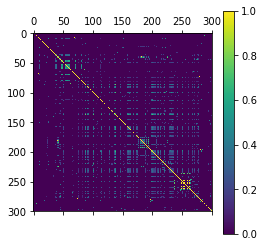

In [34]:
algoritmo = "comunidades_infomap"
cluster = infomap_clusters.sample(1).index[0]
nodos_cluster = graph_node_data[graph_node_data[algoritmo] == cluster].index.values
plt.matshow(tfidf_similarity_matrix.loc[nodos_cluster,nodos_cluster])
plt.colorbar()

display(tfidf_similarity_matrix.loc[nodos_cluster,nodos_cluster])

Calculo la similaridad media por cluster

In [35]:
def mean_similarity(similarity_matrix, cluster, algoritmo):
    nodos_cluster = graph_node_data[graph_node_data[algoritmo] == cluster].index.values
    cluster_matrix = similarity_matrix.loc[nodos_cluster,nodos_cluster]
    return round(cluster_matrix.sum().sum()/cluster_matrix.size, 2)

In [36]:
infomap_clusters["mean_similarity_tfidf"] = pd.Series({cluster:mean_similarity(tfidf_similarity_matrix, cluster, "comunidades_infomap") for cluster in infomap_clusters.index.values})
louvain_clusters["mean_similarity_tfidf"] = pd.Series({cluster:mean_similarity(tfidf_similarity_matrix, cluster, "comunidades_louvain") for cluster in louvain_clusters.index.values})

fig1 = px.histogram(infomap_clusters.mean_similarity_tfidf, width=800, height=400, title="Infomap").update_layout(yaxis_title="Clusters")
fig1.show()

fig2 = px.histogram(louvain_clusters.mean_similarity_tfidf, width=800, height=400, title="Louvain").update_layout(yaxis_title="Clusters")
fig2.show()

Para ver si es significativa no me alcanza con ver los valores absolutos, lo voy a comparar con la similaridad media que obtengo tomando pared de nodos al azar.

Por un lado está la partición infomap, tengo criterios de similaridad de genes compartidos o similaridad TF-IDF. La idea es ver si los elementos de los clusters infomap son similares entre si segun estos criterios. 

Para cada cluster infomap, calcular la similaridad media de sus componentes y calcular una distribución de estos mismos valores para pares tomados al azar. 
Estandarizar: (z = x- <x>)/sigma -> sobre el sampleo nulo. También se puede ver el p-value.
Grafico z en función del tamaño.

Zgen vs ZIDF y tamaño-> tamaño del cluster y veo todo junto

Lo voy a hacer así:
Ya calculé la similaridad media de nodos de cada cluster. Ahora tengo que ver cual es la similaridad media para nodos random. Entonces tengo que elegir pares de nodos al azar y calcularles la similaridad, hacerlo suficientes veces para tener una distribución y ver la media de eso. Compararlo con la sim. media que me dieron los clusters.

In [51]:
node_indexes = graph_node_data[graph_node_data.node_type == "disease"].index.values
n_samples = 20000
values = []
while len(values) < n_samples:
    pair = np.random.choice(node_indexes,2)
    pair_similarity = tfidf_similarity_matrix.loc[pair[0],pair[1]]
    values.append(pair_similarity)


Similaridad media para pares al azar: 0.003


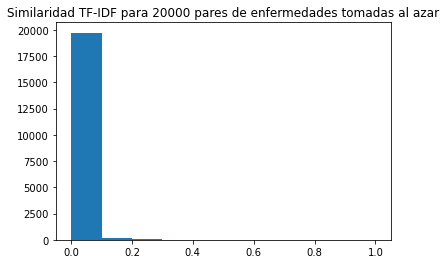

In [52]:
plt.hist(values)
plt.title(f"Similaridad TF-IDF para {n_samples} pares de enfermedades tomadas al azar")
print(f"Similaridad media para pares al azar: {round(np.mean(values),3)}")

Como la similaridad media de pares random medio básicamente 0, voy a graficar directamente la similaridad media por cluster

In [50]:
fig1 = px.scatter(infomap_clusters, x="tamaño",y="mean_similarity_tfidf", title="Similaridad media vs tamaño de cluster, Infomap").update_layout(yaxis_title="Similaridad media")
fig1.show()

fig2 = px.scatter(louvain_clusters, x="tamaño",y="mean_similarity_tfidf", title="Similaridad media vs tamaño de cluster, Louvain").update_layout(yaxis_title="Similaridad media")
fig2.show()

# Expando vocabulario

In [53]:
data_external = "../../data/external/"
primekg_data = pd.read_csv(data_external+"primekg_disease_features.csv")
disgenet_data = pd.read_csv(data_external+"disease_mappings_to_attributes.tsv", sep="\t")
my_map = pd.read_csv(data_interim +"mondo_cui_map.csv")

In [54]:
enfermedades = graph_node_data[graph_node_data.node_type == "disease"]
enfermedades = pd.merge(enfermedades, my_map, how="left", left_on="node_id", right_on="CUI")
enfermedades = pd.merge(enfermedades,primekg_data, how="left", left_on="mondo", right_on="mondo_id").drop_duplicates(subset="node_id")
enfermedades[(enfermedades.mondo_definition.isna()) & (enfermedades.umls_description.isna()) & (enfermedades.orphanet_clinical_description.isna())]

,node_idx,node_id,node_type,node_name,node_source,disgenet_type,diseaseClassMSH,diseaseClassNameMSH,comunidades_infomap,comunidades_louvain,...,orphanet_prevalence,orphanet_epidemiology,orphanet_clinical_description,orphanet_management_and_treatment,mayo_symptoms,mayo_causes,mayo_risk_factors,mayo_complications,mayo_prevention,mayo_see_doc
0,9703,C0000737,disease,Abdominal Pain,disgenet,phenotype,C23,"Pathological Conditions, Signs and Symptoms",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,9705,C0000768,disease,Congenital Abnormality,disgenet,group,C16,"Congenital, Hereditary, and Neonatal Diseases ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9706,C0000771,disease,"Abnormalities, Drug-Induced",disgenet,group,C16,"Congenital, Hereditary, and Neonatal Diseases ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9707,C0000772,disease,Multiple congenital anomalies,disgenet,group,C16,"Congenital, Hereditary, and Neonatal Diseases ...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,9708,C0000786,disease,Spontaneous abortion,disgenet,phenotype,C13,Female Urogenital Diseases and Pregnancy Compl...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33171,35626,CN244943,disease,Jaberi-Elahi syndrome,primekg,NaN,NaN,NaN,117.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33172,35627,CN248510,disease,"developmental delay, intellectual disability, ...",primekg,NaN,NaN,NaN,116.0,26.0,...,NaN,NaN,NaN,NaN,Obesity is diagnosed when your body mass index...,"Although there are genetic, behavioral, metabo...",Obesity usually results from a combination of ...,People with obesity are more likely to develop...,"Whether you're at risk of obesity, currently o...","When to see a doctor, If you're concerned abou..."
33173,35628,CN248526,disease,humerofemoral hypoplasia with radiotibial ray ...,primekg,NaN,NaN,NaN,116.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33174,35629,CN252646,disease,intellectual developmental disorder with or wi...,primekg,NaN,NaN,NaN,116.0,26.0,...,NaN,NaN,NaN,NaN,Because epilepsy is caused by abnormal activit...,Epilepsy has no identifiable cause in about ha...,Certain factors may increase your risk of epil...,Having a seizure at certain times can lead to ...,NaN,"When to see a doctor, Seek immediate medical h..."


In [55]:
def node_as_document(node_idx,join_titles=True):
    data = enfermedades.loc[enfermedades["node_idx"] == node_idx, ["node_name","mondo_definition","umls_description","orphanet_definition"]].values.astype(str)
    data = np.delete(data,np.where(data[0] == "nan"))
    data = np.char.lower(data.astype(str))
    data = remove_symbols(data)
    if join_titles:
        document = " ".join(data)
        document = document + " "
        document = document.replace(". ", " ")
    else:
        document = data
    return document

In [57]:
aver = node_as_document(11047)

In [78]:
enfermedades[enfermedades.node_name.apply(lambda x: "." in str(x))]
chromosome_id = 17034
aver = node_as_document(chromosome_id)

In [73]:
aver

'chromosome 22q11.2 microduplication syndrome the newly described 22q11.2 microduplication syndrome  dup22q11 syndrome  is the association of a broad clinical spectrum and a duplication of the region that is deleted in patients with digeorge or velocardiofacial syndrome  dg vcfs   establishing a complementary duplication syndrome. the association of a broad clinical spectrum and a duplication of the region that is deleted in patients with digeorge or velocardiofacial  establishing a complementary duplication syndrome. the clinical presentation of patients is extremely variable and shares features with 22q11.2 deletion syndromes including heart defects  urogenital abnormalities  velopharyngeal insufficiency with or without cleft palate  and ranging from multiple defects to mild learning difficulties with some individuals being essentially normal. a rare chromosomal anomaly characterized by an extremely variable clinical phenotype and may include heart defects  urogenital abnormalities  

In [81]:
aver = aver+ " "
aver.replace(". ", "JEJO")

'chromosome 22q11.2 microduplication syndrome the newly described 22q11.2 microduplication syndrome  dup22q11 syndrome  is the association of a broad clinical spectrum and a duplication of the region that is deleted in patients with digeorge or velocardiofacial syndrome  dg vcfs   establishing a complementary duplication syndromeJEJOthe association of a broad clinical spectrum and a duplication of the region that is deleted in patients with digeorge or velocardiofacial  establishing a complementary duplication syndromeJEJOthe clinical presentation of patients is extremely variable and shares features with 22q11.2 deletion syndromes including heart defects  urogenital abnormalities  velopharyngeal insufficiency with or without cleft palate  and ranging from multiple defects to mild learning difficulties with some individuals being essentially normalJEJOa rare chromosomal anomaly characterized by an extremely variable clinical phenotype and may include heart defects  urogenital abnormali

In [692]:
corpus = [node_as_document(node_id) for node_id in enfermedades.node_idx.values]
ids = enfermedades.node_idx.values

tfidf_similarity_matrix_extended = tfidf_similarity(corpus,ids,(1,3))

,9768,11782,14636,28400,28522,28897,28898,29083,29257,29854,30739,30740,34811,34985,35048,35579
9768,1.000000,0.050400,0.179318,0.123114,0.238635,0.000000,0.543581,0.039509,0.413816,0.302992,0.162097,0.000000,0.000000,0.143536,0.000000,0.000000
11782,0.050400,1.000000,0.007374,0.013768,0.020700,0.000000,0.047151,0.754515,0.035895,0.026282,0.032646,0.000000,0.016565,0.012451,0.018983,0.000000
14636,0.179318,0.007374,1.000000,0.021101,0.040901,0.000000,0.093166,0.006772,0.070926,0.051931,0.033478,0.000000,0.007732,0.524093,0.020232,0.000000
28400,0.123114,0.013768,0.021101,1.000000,0.071573,0.007271,0.163034,0.015277,0.141979,0.090876,0.057636,0.000000,0.000000,0.043050,0.000000,0.000000
28522,0.238635,0.020700,0.040901,0.071573,1.000000,0.107077,0.316016,0.022969,0.710090,0.176147,0.078027,0.000000,0.000000,0.083446,0.000000,0.000000
28897,0.000000,0.000000,0.000000,0.007271,0.107077,1.000000,0.000000,0.000000,0.016293,0.000000,0.015853,0.000000,0.014192,0.000000,0.000000,0.000000
28898,0.543581,0.047151,0.093166,0.163034,0.316016,0.000000,1.000000,0.052321,0.548001,0.401241,0.177735,0.000000,0.000000,0.190080,0.000000,0.000000
29083,0.039509,0.754515,0.006772,0.015277,0.022969,0.000000,0.052321,1.000000,0.039831,0.029164,0.019953,0.025695,0.143090,0.013816,0.026149,0.000000
29257,0.413816,0.035895,0.070926,0.141979,0.710090,0.016293,0.548001,0.039831,1.000000,0.305456,0.174255,0.000000,0.000000,0.144704,0.000000,0.000000
29854,0.302992,0.026282,0.051931,0.090876,0.176147,0.000000,0.401241,0.029164,0.305456,1.000000,0.099069,0.000000,0.000000,0.105951,0.000000,0.000000


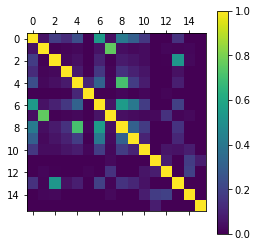

In [695]:
algoritmo = "comunidades_infomap"
cluster = infomap_clusters.sample(1).index[0]
nodos_cluster = graph_node_data[graph_node_data[algoritmo] == cluster].index.values
plt.matshow(tfidf_similarity_matrix_extended.loc[nodos_cluster,nodos_cluster])
plt.colorbar()

display(tfidf_similarity_matrix_extended.loc[nodos_cluster,nodos_cluster])

In [696]:
infomap_clusters["mean_similarity_tfidf_extended"] = pd.Series({cluster:mean_similarity(tfidf_similarity_matrix_extended, cluster, "comunidades_infomap") for cluster in infomap_clusters.index.values})
louvain_clusters["mean_similarity_tfidf_extended"] = pd.Series({cluster:mean_similarity(tfidf_similarity_matrix_extended, cluster, "comunidades_louvain") for cluster in louvain_clusters.index.values})

fig1 = px.histogram(infomap_clusters.mean_similarity_tfidf_extended, width=800, height=400, title="Infomap").update_layout(yaxis_title="Clusters")
fig1.show()

fig2 = px.histogram(louvain_clusters.mean_similarity_tfidf_extended, width=800, height=400, title="Louvain").update_layout(yaxis_title="Clusters")
fig2.show()

Similaridad media para pares al azar: 0.005


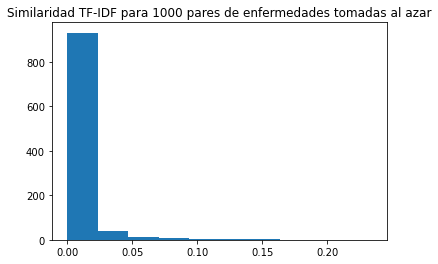

In [691]:
node_indexes = graph_node_data[graph_node_data.node_type == "disease"].index.values
n_samples = 1000
values = []
while len(values) < n_samples:
    pair = np.random.choice(node_indexes,2)
    pair_similarity = tfidf_similarity_matrix_extended.loc[pair[0],pair[1]]
    values.append(pair_similarity)

plt.hist(values)
plt.title(f"Similaridad TF-IDF para {n_samples} pares de enfermedades tomadas al azar")
print(f"Similaridad media para pares al azar: {round(np.mean(values),3)}")

In [ ]:
def cluster_as_document_expanded(cluster_id,cluster_algorithm,join_titles=True):
    content = enfermedades.loc[enfermedades[cluster_algorithm] == cluster_id, ["node_name","mondo_definition","umls_description","orphanet_definition"]].values.astype(str)
    content = np.char.lower(content)
    content = remove_symbols(content)
    if join_titles:
        document = " ".join(content)
    else:
        document = content
    return document